This notebook is created to practice Attention based NLP models.

Most of the code is taken from LinkedIn course:

https://www.linkedin.com/learning/introduction-to-attention-based-neural-networks/implementing-bahdanau-attention

I  put all the blocks of code together in one notebook and made the detailed comments.
This will help to understand the concept of Transformers and learn the Attention based models architecture easier.

Your comments and elaboration ideas on that project are highly appreciated!



<h2>Exploring the dataset</h2>
<p>Reading the image data and their corresponding captions from the flick dataset folder. Showing the image and captions to get the insighs of the data. Dowload link for the dataset used <a href="https://www.kaggle.com/adityajn105/flickr8k">here</a></p>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
  %cd /content/drive/MyDrive/image_caption

/content/drive/MyDrive/image_caption


In [ ]:
ls

flickr8k/                   img_caption_vit.pth    VIT_large_gpt2/
flickr8kimagescaptions.zip  kaggle.json            vocab.pkl
img_caption.pth             my_checkpoint.pth.tar


In [ ]:
#location of the data 
data_location =  "flickr8k"
!ls $data_location

captions.txt  images  results.csv


In [ ]:
#reading the text data 
import pandas as pd
caption_file = data_location + '/captions.txt'
df = pd.read_csv(caption_file)
print("There are {} image to captions".format(len(df)))
df.head(7)

There are 40455 image to captions


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...


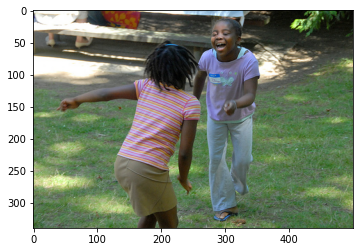

Caption: Two children are laughing in the grass .
Caption: Two girls laughing outside in a yard .
Caption: Two girls standing on grass face each other .
Caption: Two young girls are playing and laughing in a green grassy yard .
Caption: Two young girls playing together .


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#select any index from the whole dataset 
#single image has 5 captions
#so, select indx as: 1,6,11,16...
data_idx = 900

#eg path to be plot: ../input/flickr8k/Images/1000268201_693b08cb0e.jpg
image_path = data_location+"/images/"+df.iloc[data_idx,0]
img=mpimg.imread(image_path)
plt.imshow(img)
plt.show()

#image consits of 5 captions,
#showing all 5 captions of the image of the given idx 
for i in range(data_idx,data_idx+5):
    print("Caption:",df.iloc[i,1])


# Custom dataset with Vocabulary

<p>Writing the custom torch dataset class so, that we can abastract out the dataloading steps during the training and validation process</p>
<p>Here, dataloader is created which gives the batch of image and its captions with following processing done:</p>

<li>caption word tokenized to unique numbers</li>
<li>vocab instance created to store all the relivent words in the datasets</li>
<li>each batch, caption padded to have same sequence length</li>
<li>image resized to the desired size and converted into captions</li>

<br><p>In this way the dataprocessing is done, and the dataloader is ready to be used with <b>Pytorch</b></p>

In [ ]:
#imports 
import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

from PIL import Image

In [ ]:
#using spacy for the better text tokenization 
spacy_eng = spacy.load("en_core_web_sm")

#example
text = "This is a good place to find a city"
[token.text.lower() for token in spacy_eng.tokenizer(text)]

['this', 'is', 'a', 'good', 'place', 'to', 'find', 'a', 'city']

In [ ]:
class Vocabulary:
    def __init__(self,freq_threshold):
        #setting the pre-reserved tokens int to string tokens
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        
        #string to int tokens
        #its reverse dict self.itos
        self.stoi = {v:k for k,v in self.itos.items()}
        
        self.freq_threshold = freq_threshold
        
    def __len__(self): return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]
    
    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]    

In [ ]:
#testing the vicab class 
v = Vocabulary(freq_threshold=1)

v.build_vocab(["This is a good place to find a city"])
print(v.stoi)
print(v.numericalize("This is a good place to find a city here!!"))

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'this': 4, 'is': 5, 'a': 6, 'good': 7, 'place': 8, 'to': 9, 'find': 10, 'city': 11}
[4, 5, 6, 7, 8, 9, 10, 6, 11, 3, 3, 3]


In [ ]:
class FlickrDataset(Dataset):
    """
    FlickrDataset
    """
    def __init__(self,root_dir,captions_file,transform=None,freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(caption_file)
        self.transform = transform
        
        #Get image and caption colum from the dataframe
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
        #Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())
        
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")
        
        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)
        
        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec)

In [ ]:
#show the tensor image
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

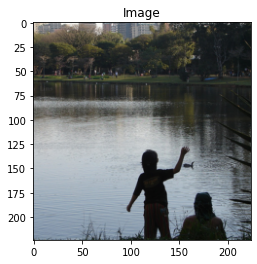

Token: tensor([  1,   4,  28,  16,   4,  80,  34,  19, 766, 163,   8,   4, 250, 215,
          5,   2])
Sentence:
['<SOS>', 'a', 'child', 'and', 'a', 'woman', 'are', 'at', 'waters', 'edge', 'in', 'a', 'big', 'city', '.', '<EOS>']


In [ ]:
#defining the transform to be applied
transforms = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

#testing the dataset class
dataset =  FlickrDataset(
    root_dir = data_location+"/images",
    captions_file = data_location+"/captions.txt",
    transform=transforms
)



img, caps = dataset[80]
show_image(img,"Image")
print("Token:",caps)
print("Sentence:")
print([dataset.vocab.itos[token] for token in caps.tolist()])

In [ ]:
class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

In [ ]:
#writing the dataloader
#setting the constants
BATCH_SIZE = 4
NUM_WORKER = 2

#token to represent the padding
pad_idx = dataset.vocab.stoi["<PAD>"]

data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

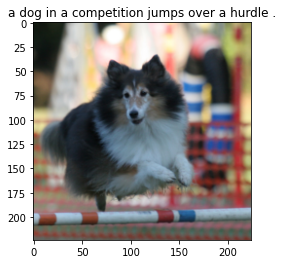

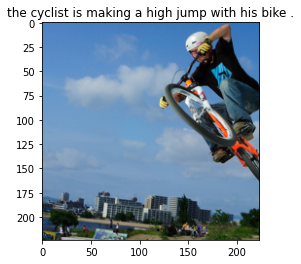

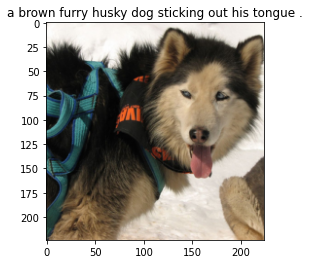

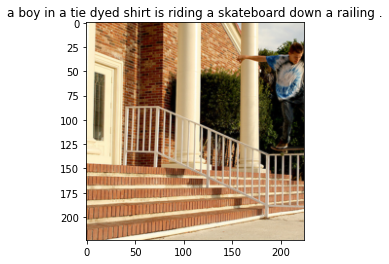

In [ ]:
#generating the iterator from the dataloader
dataiter = iter(data_loader)

#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions = batch

#showing info of image in single batch
for i in range(BATCH_SIZE):
    img,cap = images[i],captions[i]
    caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)                      
    show_image(img,caption_label)
    plt.show()

# Attention Model configuration

The model consists of three modules: EncoderCNN, Attention, and DecoderRNN.

* EncoderCNN is a pre-trained ResNet50 model that extracts feature maps from input images.
* Attention is a module that allows the DecoderRNN to pay attention to certain features in the input. It generates an alignment score between the feature map representation and the previous decoder hidden state, which is used to calculate the context vector.
* DecoderRNN generates captions given the feature map representation and the previous word prediction. It uses the attention module to generate the context vector and passes it through an LSTM cell to generate the next hidden state. The output of the LSTM cell is passed through a linear layer to generate a one-hot vector of the predicted word.

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# feature map representation from ResNet model will be used as input to our Attention model
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2] # everythin except last Conv block
        self.resnet = nn.Sequential(*modules)
        

    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features

In [ ]:
#Bahdanau Attention - allows our Decoder to pay attention to certain features (important parts)
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        # we pass encoder/decoder hidden states to weights layer
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        # generate alignment scores
        self.A = nn.Linear(attention_dim,1)
        
    # as input we accept feature map representation  and prev decoder hidden state  
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        # adding one mode dimension for combined states
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        # conversion to probabilities using softmax
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        # generating the context vector
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha,attention_weights
        


In [ ]:
# Attention Decoder module to generate captions
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        # generate embeddings for words
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        # features representation
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        # linear layer that outputs one-hot vector of predicted word
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
    # inputs are feature representation and captions (vectors)    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        # predicted captions in form of one-hot vectors
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
        
        # feed in the input for each time instance along with context vectors
        for s in range(seq_length):
            # first, pass the features and decoder hidden state
            alpha,context = self.attention(features, h)
            
            # lstm input are embeddings repr words and context vectors
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            
            # hidden state for next time instance
            h, c = self.lstm_cell(lstm_input, (h, c))
            
            # pass through dropout layer
            output = self.fcn(self.drop(h))
            
            # get the prediction and weights
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=50,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        # store the weights
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        # captions generated 
        captions = []
        
        for i in range(max_len):
            # take encoder output and compute the current attention
            alpha,context = self.attention(features, h)
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            # conatenation of current state embeddings and context vectors
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas
    
    # features from encoder CNN 
    def init_hidden_state(self, encoder_out):
        batch_size = encoder_out.size(0)
        h = torch.zeros(batch_size, self.decoder_dim).to(encoder_out.device)
        c = torch.zeros(batch_size, self.decoder_dim).to(encoder_out.device)
        return h, c

In [ ]:
# Seq2Seq model to generate image captions

class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        # encoder doesn't need any params to specify
        self.encoder = EncoderCNN()
        # decoder params need to be specified
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
    
    def forward(self, images, captions):
        # pass the images through encoder to ger feature representations
        features = self.encoder(images)
        # features and captions are passed to decoder
        outputs = self.decoder(features, captions)
        return outputs


# Setting Hypperparameter and model initialization

In [ ]:
# Hyperparams to tweak

embed_size=500
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4

In [ ]:
# Seq2Seq model initialization

model = EncoderDecoder(
    embed_size=500,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# helper function to save the model
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'attention_model_state.pth')

# Training Job from above configs

**Watch as with every epoch the generated text becomes more and more meaningful !**

Epoch: 1 Batch: 1000 loss: 3.49076
Epoch: 1 Batch: 2000 loss: 3.70598
Epoch: 1 Batch: 3000 loss: 2.70585
Epoch: 1 Batch: 4000 loss: 2.97502
Epoch: 1 Batch: 5000 loss: 2.78313
Epoch: 1 Batch: 6000 loss: 3.50147
Epoch: 1 Batch: 7000 loss: 3.32258
Epoch: 1 Batch: 8000 loss: 3.68635
Epoch: 1 Batch: 9000 loss: 3.03701
Epoch: 1 Batch: 10000 loss: 3.22194


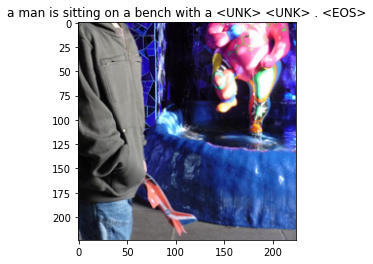

Epoch: 2 Batch: 1000 loss: 3.06276
Epoch: 2 Batch: 2000 loss: 2.61247
Epoch: 2 Batch: 3000 loss: 2.75708
Epoch: 2 Batch: 4000 loss: 3.39489
Epoch: 2 Batch: 5000 loss: 3.56292
Epoch: 2 Batch: 6000 loss: 2.39657
Epoch: 2 Batch: 7000 loss: 2.43830
Epoch: 2 Batch: 8000 loss: 2.69419
Epoch: 2 Batch: 9000 loss: 2.97676
Epoch: 2 Batch: 10000 loss: 2.07634


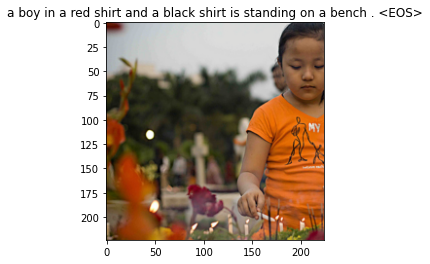

Epoch: 3 Batch: 1000 loss: 2.38849
Epoch: 3 Batch: 2000 loss: 3.14100
Epoch: 3 Batch: 3000 loss: 2.55628
Epoch: 3 Batch: 4000 loss: 3.06898
Epoch: 3 Batch: 5000 loss: 2.91304
Epoch: 3 Batch: 6000 loss: 2.84074
Epoch: 3 Batch: 7000 loss: 2.29436
Epoch: 3 Batch: 8000 loss: 2.95978
Epoch: 3 Batch: 9000 loss: 2.79870
Epoch: 3 Batch: 10000 loss: 3.00987


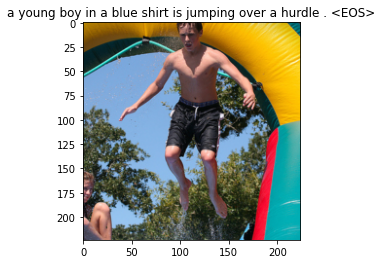

Epoch: 4 Batch: 1000 loss: 1.87372
Epoch: 4 Batch: 2000 loss: 3.00359
Epoch: 4 Batch: 3000 loss: 1.95502
Epoch: 4 Batch: 4000 loss: 2.59150
Epoch: 4 Batch: 5000 loss: 3.13244
Epoch: 4 Batch: 6000 loss: 2.80465
Epoch: 4 Batch: 7000 loss: 3.28501
Epoch: 4 Batch: 8000 loss: 2.66795
Epoch: 4 Batch: 9000 loss: 2.53887
Epoch: 4 Batch: 10000 loss: 2.60333


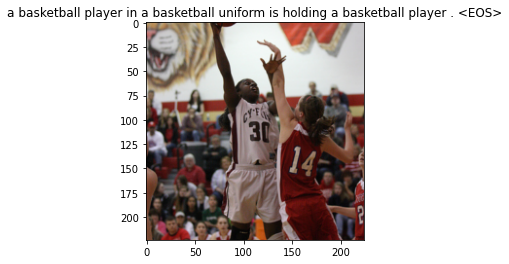

Epoch: 5 Batch: 1000 loss: 2.61240
Epoch: 5 Batch: 2000 loss: 2.70713
Epoch: 5 Batch: 3000 loss: 2.11926
Epoch: 5 Batch: 4000 loss: 2.45549
Epoch: 5 Batch: 5000 loss: 2.11953
Epoch: 5 Batch: 6000 loss: 2.72947
Epoch: 5 Batch: 7000 loss: 2.42689
Epoch: 5 Batch: 8000 loss: 2.42637
Epoch: 5 Batch: 9000 loss: 2.10213
Epoch: 5 Batch: 10000 loss: 2.86730


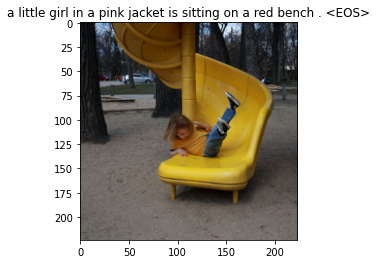

Epoch: 6 Batch: 1000 loss: 2.32458
Epoch: 6 Batch: 2000 loss: 2.97322
Epoch: 6 Batch: 3000 loss: 2.00278
Epoch: 6 Batch: 4000 loss: 2.60716
Epoch: 6 Batch: 5000 loss: 1.93304
Epoch: 6 Batch: 6000 loss: 1.91514
Epoch: 6 Batch: 7000 loss: 3.07890
Epoch: 6 Batch: 8000 loss: 2.90015
Epoch: 6 Batch: 9000 loss: 2.10502
Epoch: 6 Batch: 10000 loss: 3.02170


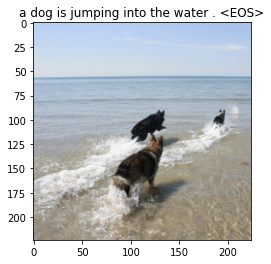

Epoch: 7 Batch: 1000 loss: 1.91179
Epoch: 7 Batch: 2000 loss: 3.25168
Epoch: 7 Batch: 3000 loss: 1.89921
Epoch: 7 Batch: 4000 loss: 2.49959
Epoch: 7 Batch: 5000 loss: 2.30326
Epoch: 7 Batch: 6000 loss: 2.15037
Epoch: 7 Batch: 7000 loss: 2.32361
Epoch: 7 Batch: 8000 loss: 2.10317
Epoch: 7 Batch: 9000 loss: 2.65789
Epoch: 7 Batch: 10000 loss: 2.22723


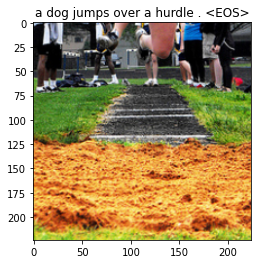

Epoch: 8 Batch: 1000 loss: 2.55305
Epoch: 8 Batch: 2000 loss: 2.11382
Epoch: 8 Batch: 3000 loss: 2.86034
Epoch: 8 Batch: 4000 loss: 1.93535
Epoch: 8 Batch: 5000 loss: 2.12391
Epoch: 8 Batch: 6000 loss: 2.69974
Epoch: 8 Batch: 7000 loss: 1.78747
Epoch: 8 Batch: 8000 loss: 3.03212
Epoch: 8 Batch: 9000 loss: 2.63157
Epoch: 8 Batch: 10000 loss: 2.55103


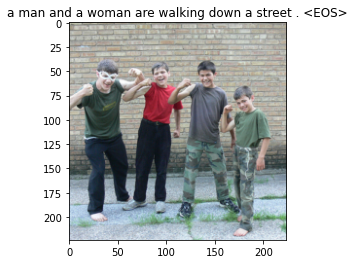

Epoch: 9 Batch: 1000 loss: 2.73437
Epoch: 9 Batch: 2000 loss: 2.29545
Epoch: 9 Batch: 3000 loss: 2.11703
Epoch: 9 Batch: 4000 loss: 2.51772
Epoch: 9 Batch: 5000 loss: 2.61922
Epoch: 9 Batch: 6000 loss: 2.34833
Epoch: 9 Batch: 7000 loss: 2.78306
Epoch: 9 Batch: 8000 loss: 2.05854
Epoch: 9 Batch: 9000 loss: 2.84093
Epoch: 9 Batch: 10000 loss: 2.31068


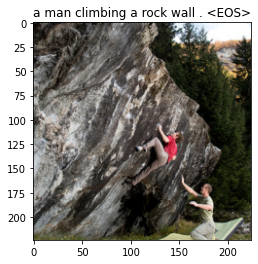

Epoch: 10 Batch: 1000 loss: 2.14362
Epoch: 10 Batch: 2000 loss: 2.61958
Epoch: 10 Batch: 3000 loss: 2.21476
Epoch: 10 Batch: 4000 loss: 2.24699
Epoch: 10 Batch: 5000 loss: 2.65135
Epoch: 10 Batch: 6000 loss: 2.15754
Epoch: 10 Batch: 7000 loss: 2.22922
Epoch: 10 Batch: 8000 loss: 2.22993
Epoch: 10 Batch: 9000 loss: 2.26814
Epoch: 10 Batch: 10000 loss: 2.90798


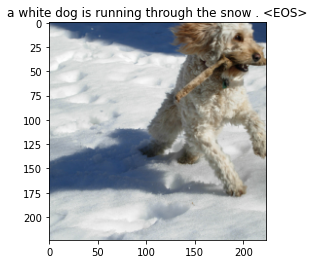

Epoch: 11 Batch: 1000 loss: 2.15377
Epoch: 11 Batch: 2000 loss: 2.36615
Epoch: 11 Batch: 3000 loss: 2.66318
Epoch: 11 Batch: 4000 loss: 2.70600
Epoch: 11 Batch: 5000 loss: 1.82334
Epoch: 11 Batch: 6000 loss: 2.47743
Epoch: 11 Batch: 7000 loss: 2.33779
Epoch: 11 Batch: 8000 loss: 2.33970
Epoch: 11 Batch: 9000 loss: 2.37926
Epoch: 11 Batch: 10000 loss: 2.63753


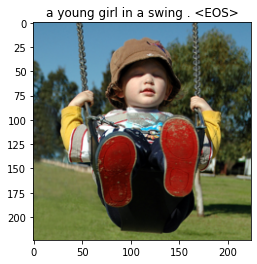

Epoch: 12 Batch: 1000 loss: 1.79711
Epoch: 12 Batch: 2000 loss: 3.19135
Epoch: 12 Batch: 3000 loss: 2.01214
Epoch: 12 Batch: 4000 loss: 2.63335
Epoch: 12 Batch: 5000 loss: 1.89860
Epoch: 12 Batch: 6000 loss: 2.26187
Epoch: 12 Batch: 7000 loss: 2.72880
Epoch: 12 Batch: 8000 loss: 2.40560
Epoch: 12 Batch: 9000 loss: 2.16218
Epoch: 12 Batch: 10000 loss: 2.63696


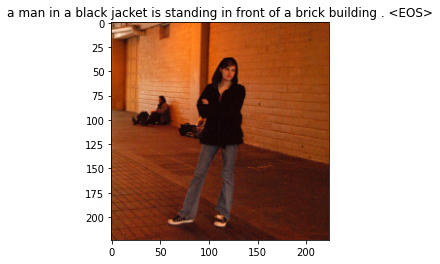

In [ ]:
num_epochs = 25
print_every = 1000

for epoch in range(1,num_epochs+1):
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} Batch: {} loss: {:.5f}".format(epoch, idx+1, loss.item()))
        
    #generate the caption and display it
    model.eval()
    with torch.no_grad():
        dataiter = iter(data_loader)
        img,_ = next(dataiter)
        features = model.encoder(img[0:1].to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(img[0],title=caption)

    model.train()

    #save the latest model after every epoch
    save_model(model,epoch)

# Visualizing the model'a attention

In [ ]:
# For visualising attentions following helper functions are defined. 
# generate_caps-Given the image generate captions and attention scores show_attention-Plot the attention scores in the image

In [ ]:
# generate caption
def get_caps_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps,alphas

In [ ]:
# Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()

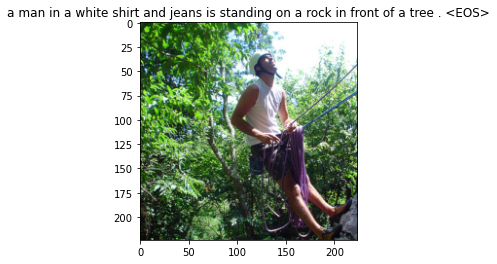

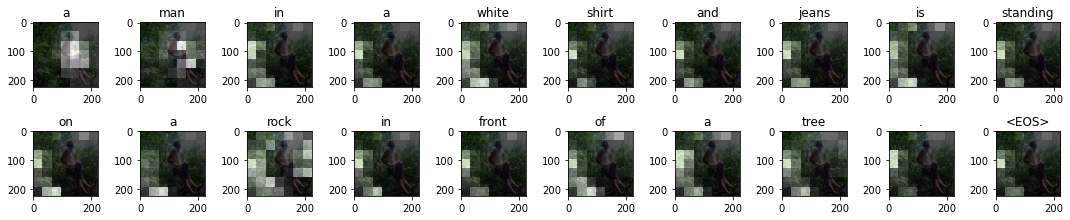

In [ ]:
# show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

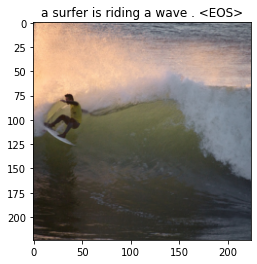

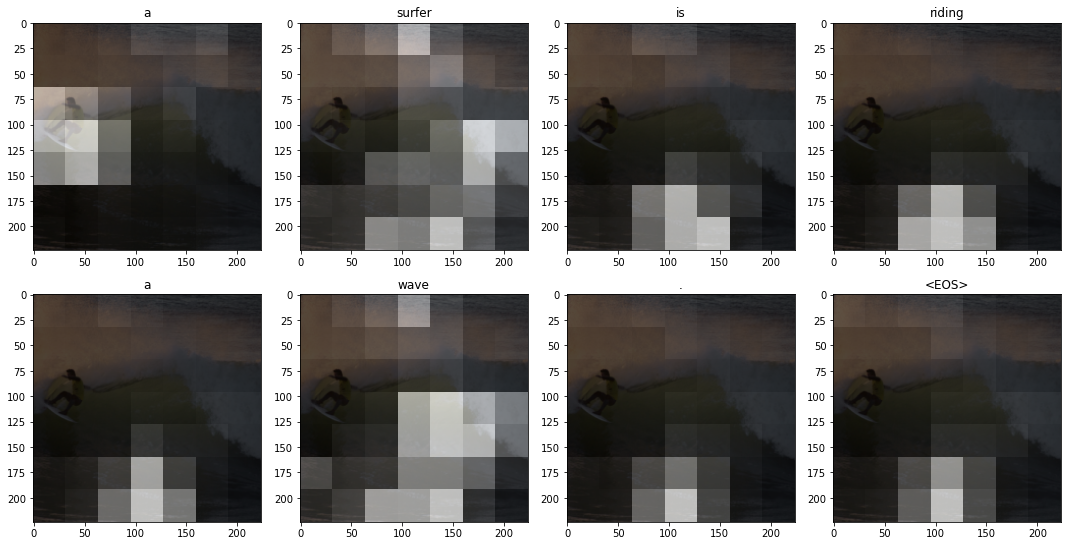

In [ ]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

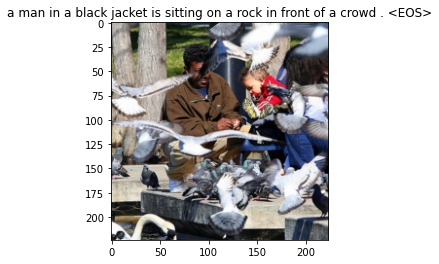

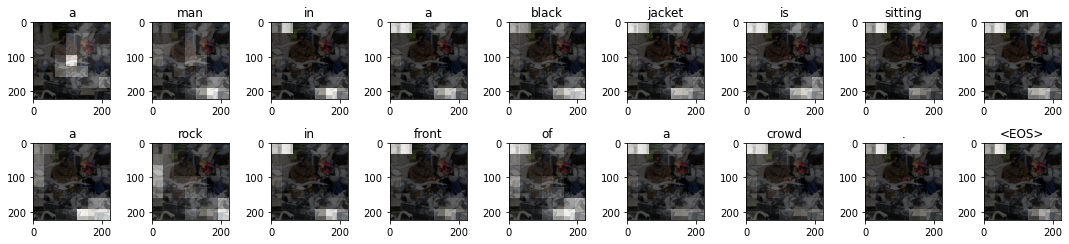

In [ ]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

# Next steps

1. Evluate model with BLEU scores
2. Improve the model architecture to get better predictions
3. Make Image-to-Audio block to pronounce generated text from image